<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

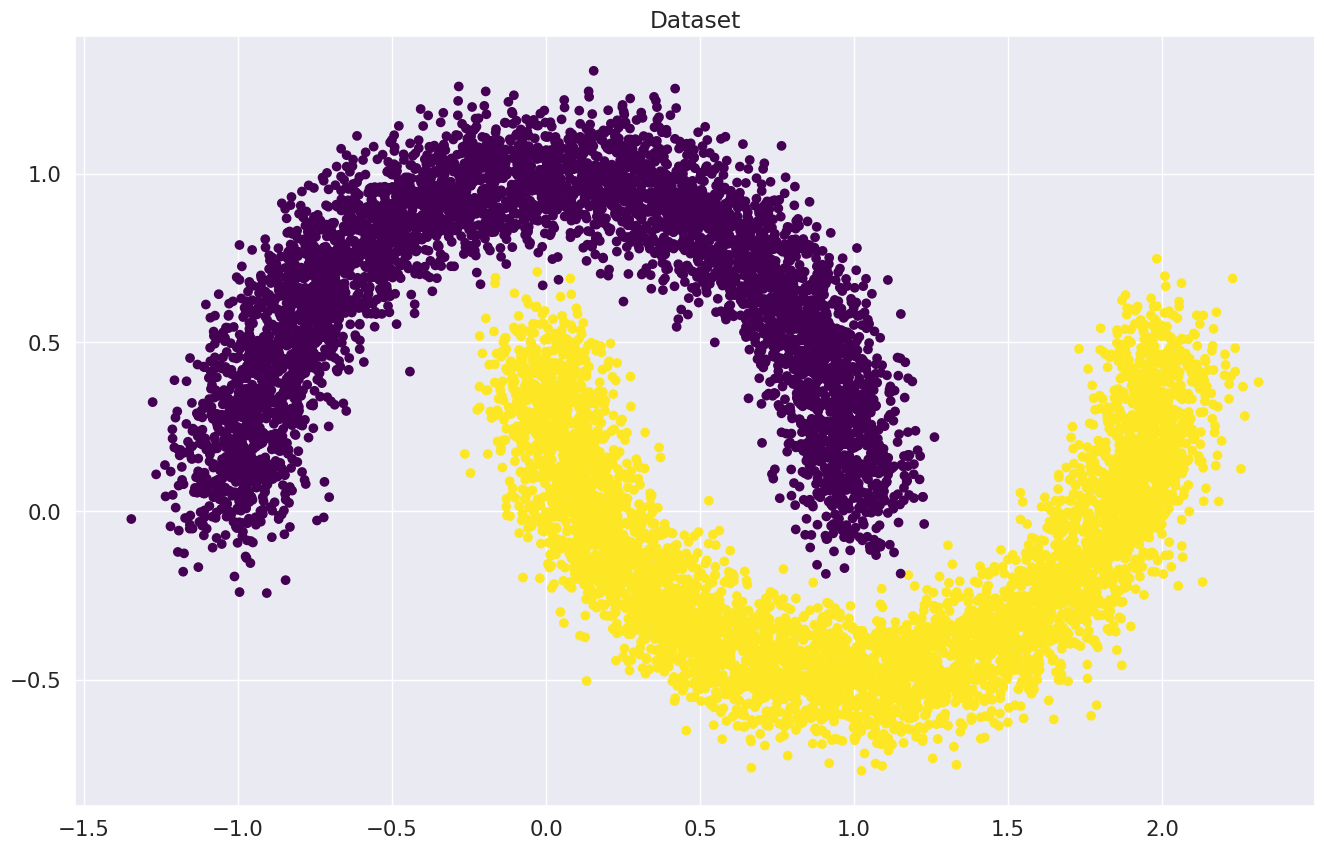

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.randn(1, out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        x = torch.matmul(x, self.weights)
        if self.bias is not None:
            x += self.bias
        return x

x_dumb = torch.rand((128, 8), dtype=torch.float, requires_grad=True)

lr = LinearRegression(8, 10, bias=False)

y_dumb = lr(x_dumb)

print(x_dumb.shape)
print(y_dumb.shape)

torch.Size([128, 8])
torch.Size([128, 10])


In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [9]:
def count_parameters(model):
    """
    Calculation of train parameters
    return (all_params, trainable_params)
    """
    all_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return all_params, trainable_params

all_params, trainable_params = count_parameters(linear_regression)
print(f"Ответ: {trainable_params} параметра из {all_params} обучаемы")

Ответ: 3 параметра из 3 обучаемы


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        y_batch = y_batch.float()
        y_pred = linear_regression(X_batch)
        y_pred = y_pred.squeeze()
        loss = loss_function(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().flatten()[0])
        
        preds = (y_pred.detach() > 0.5).long()
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break

        prev_weights = current_weights

    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.7734375
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8203125
Iteration: 400
Batch accuracy: 0.8359375
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.7890625
Iteration: 800
Batch accuracy: 0.8046875

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**  696 итераций.

### Визуализируем результаты

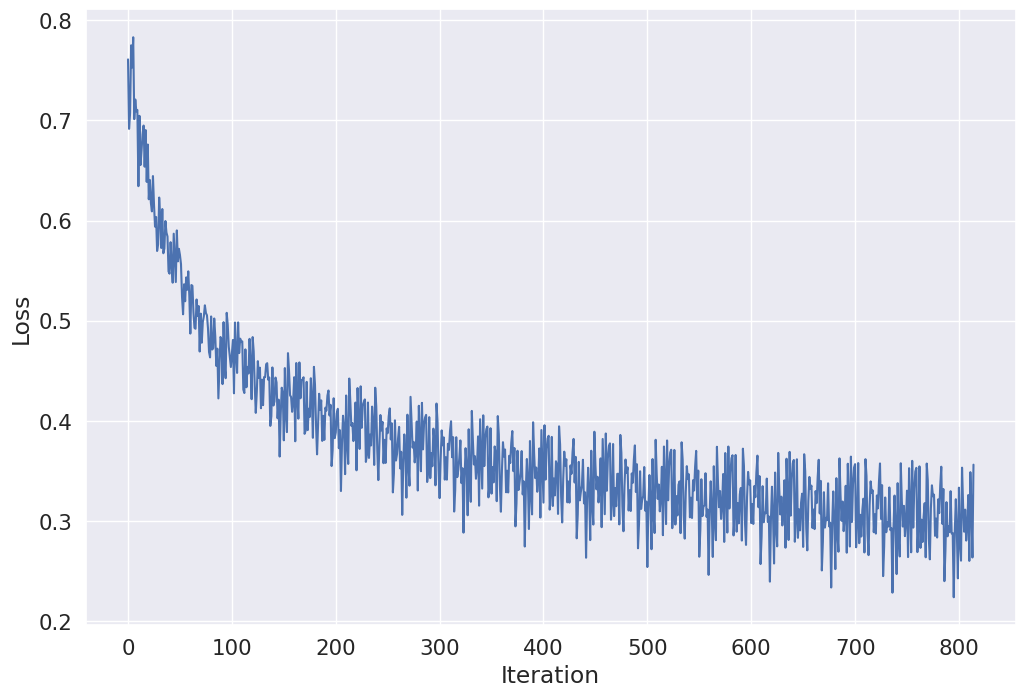

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

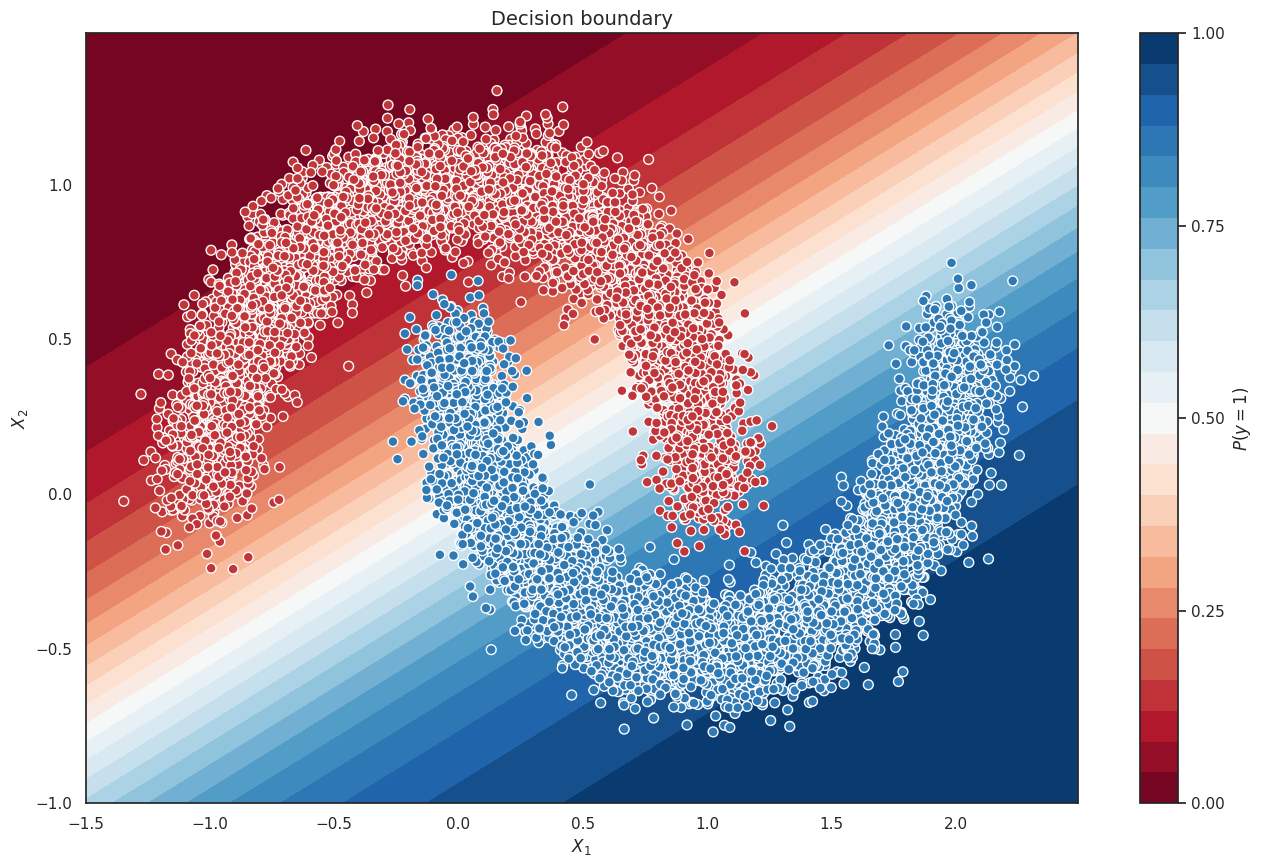

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        preds = preds > 0.5
        preds = preds.detach().cpu().numpy()
        predictions = np.append(predictions, preds)
    return predictions

In [14]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)

acc = accuracy_score(y_val, y_pred)
print(acc)

0.8664


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  0.8772

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [15]:
import os
import torchvision.transforms as tfs
from torchvision.datasets import MNIST

EPOCHS = 31

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
def get_model(activation=nn.ELU):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        activation(),
        nn.Linear(512, 512),
        activation(),
        nn.Linear(512, 10),
    )

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [18]:
def run(model, max_epoch=10, lr=3e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr)

    loaders = {
        "train": train_dataloader,
        "valid": valid_dataloader,
    }

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    accuracy = {
        "train": [],
        "valid": [],
    }
    for epoch in range(max_epoch):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    y_pred = model(x_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        y_pred = model(x_batch)
                preds = y_pred.argmax(-1)
                correct = (preds.flatten() == y_batch).type(torch.float32).sum()
                all_ = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all_
            accuracy[k].append(epoch_correct/epoch_all)
            if epoch % 5 == 0:
                print(f"Epoch: {epoch+1}. Loader: {k}. Accuracy: {epoch_correct/epoch_all:.5f}")

    return accuracy

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [19]:
def test_activation_function(activation):
    model = get_model(activation)
    accuracy = run(model, max_epoch=EPOCHS, lr=1e-3)
    return accuracy

plain_accuracy = test_activation_function(Identical)
elu_accuracy = test_activation_function(nn.ELU)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1. Loader: train. Accuracy: 0.86757
Epoch: 1. Loader: valid. Accuracy: 0.90010
Epoch: 6. Loader: train. Accuracy: 0.90670
Epoch: 6. Loader: valid. Accuracy: 0.91270
Epoch: 11. Loader: train. Accuracy: 0.91282
Epoch: 11. Loader: valid. Accuracy: 0.91410
Epoch: 16. Loader: train. Accuracy: 0.91560
Epoch: 16. Loader: valid. Accuracy: 0.91890
Epoch: 21. Loader: train. Accuracy: 0.91888
Epoch: 21. Loader: valid. Accuracy: 0.91980
Epoch: 26. Loader: train. Accuracy: 0.92078
Epoch: 26. Loader: valid. Accuracy: 0.91990
Epoch: 31. Loader: train. Accuracy: 0.92028
Epoch: 31. Loader: valid. Accuracy: 0.91660
Epoch: 1. Loader: train. Accuracy: 0.90393
Epoch: 1. Loader: valid. Accuracy: 0.94850
Epoch: 6. Loader: train. Accuracy: 0.98088
Epoch: 6. Loader: valid. Accuracy: 0.97350
Epoch: 11. Loader: train. Accuracy: 0.98792
Epoch: 11. Loader: valid. Accuracy: 0.97600
Epoch: 16. Loader: train. Accuracy: 0.98982
Epoch: 16. Loader: valid. Accuracy: 0.97670
Epoch: 21. Loader: train. Accuracy: 0.99

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

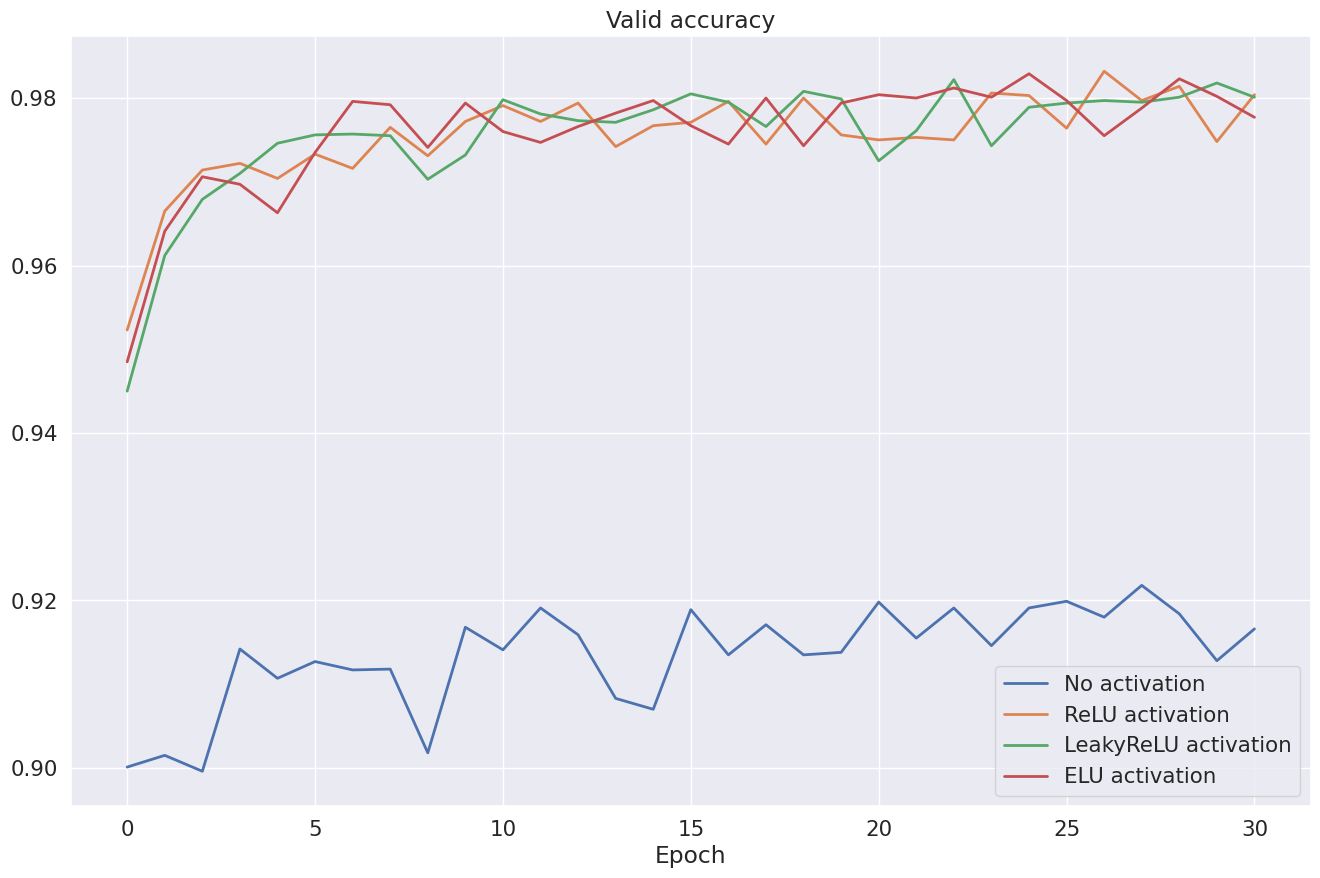

In [20]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(EPOCHS), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(EPOCHS), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(EPOCHS), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(EPOCHS), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

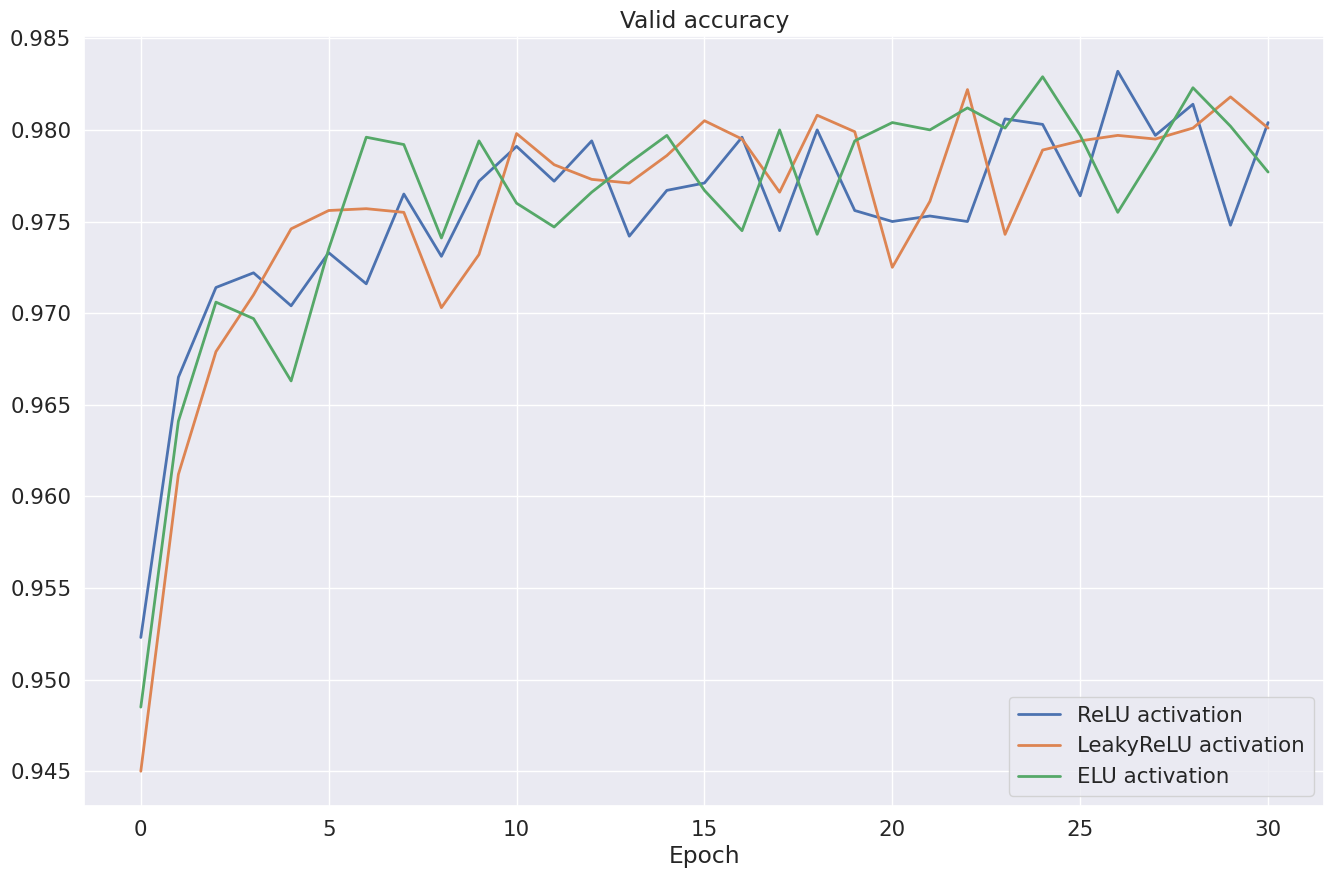

In [21]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(EPOCHS), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(EPOCHS), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(EPOCHS), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [22]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-04 20:49:06--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-04 20:49:06--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.04s   

2023-04-04 20:49:07 (1

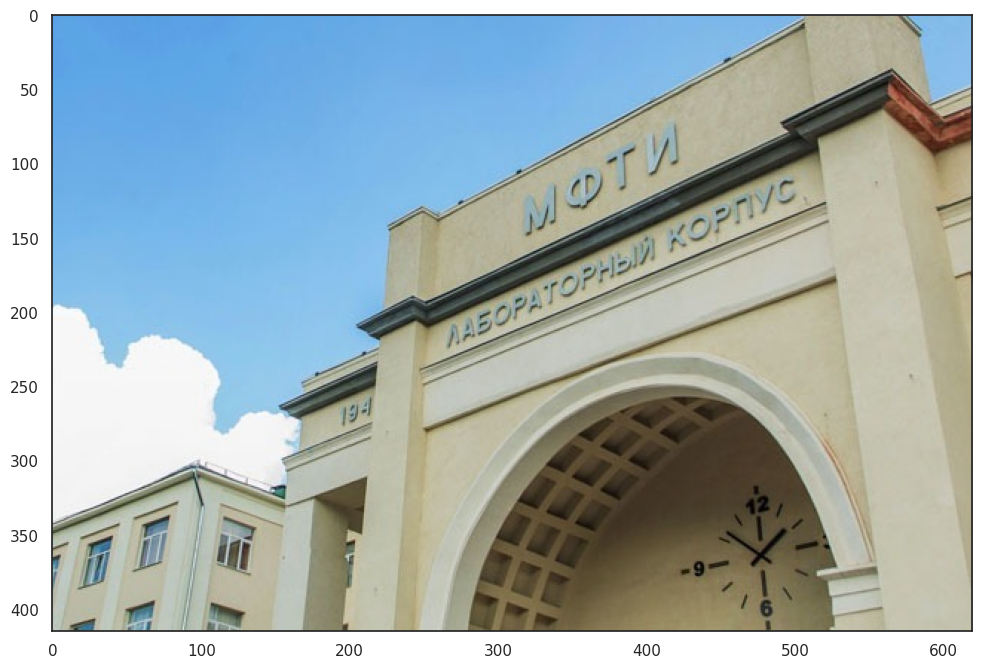

In [23]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [24]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


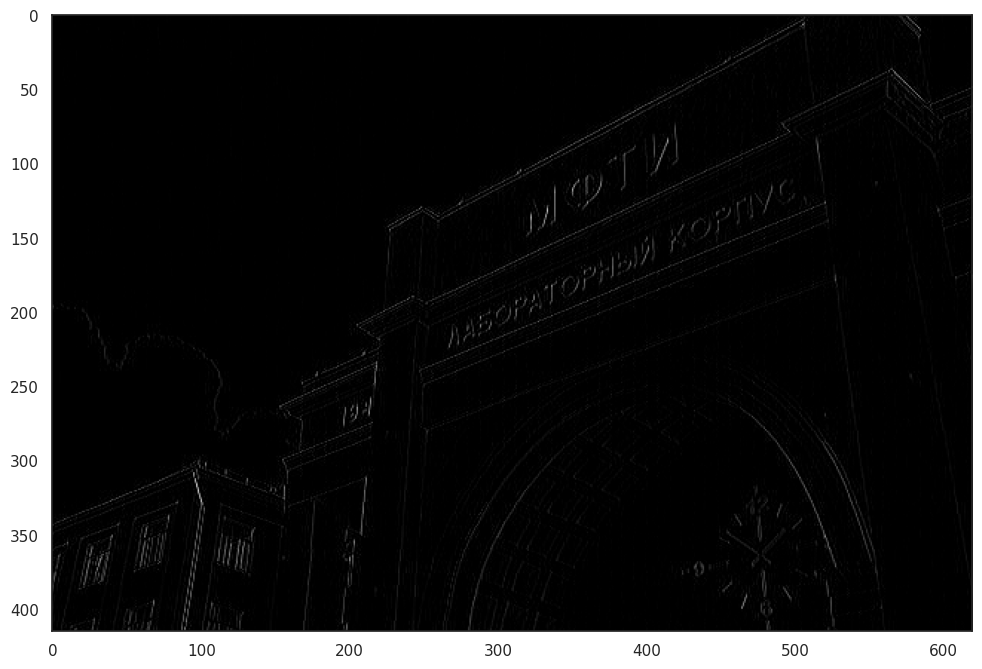

In [25]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [26]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc3(x)
        return x


In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

# test_model
x_dumb = torch.rand((128, 1, 28, 28), dtype=torch.float, device=device)
y_dumb = model(x_dumb)
print(x_dumb.shape)
print(y_dumb.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [28]:
accuracy = run(LeNet(), max_epoch=EPOCHS, lr=1e-3)

Epoch: 1. Loader: train. Accuracy: 0.87013
Epoch: 1. Loader: valid. Accuracy: 0.95770
Epoch: 6. Loader: train. Accuracy: 0.98542
Epoch: 6. Loader: valid. Accuracy: 0.98660
Epoch: 11. Loader: train. Accuracy: 0.99152
Epoch: 11. Loader: valid. Accuracy: 0.99040
Epoch: 16. Loader: train. Accuracy: 0.99480
Epoch: 16. Loader: valid. Accuracy: 0.98940
Epoch: 21. Loader: train. Accuracy: 0.99645
Epoch: 21. Loader: valid. Accuracy: 0.99070
Epoch: 26. Loader: train. Accuracy: 0.99715
Epoch: 26. Loader: valid. Accuracy: 0.99080
Epoch: 31. Loader: train. Accuracy: 0.99830
Epoch: 31. Loader: valid. Accuracy: 0.99120


In [29]:
lenet_accuracy = accuracy
print(lenet_accuracy["valid"])

[0.9577, 0.9723, 0.9769, 0.9847, 0.986, 0.9866, 0.9871, 0.9888, 0.988, 0.9885, 0.9904, 0.9885, 0.9903, 0.991, 0.989, 0.9894, 0.9911, 0.99, 0.9895, 0.9902, 0.9907, 0.9902, 0.9896, 0.9906, 0.9906, 0.9908, 0.9914, 0.9904, 0.9895, 0.9904, 0.9912]


Сравним с предыдущем пунктом

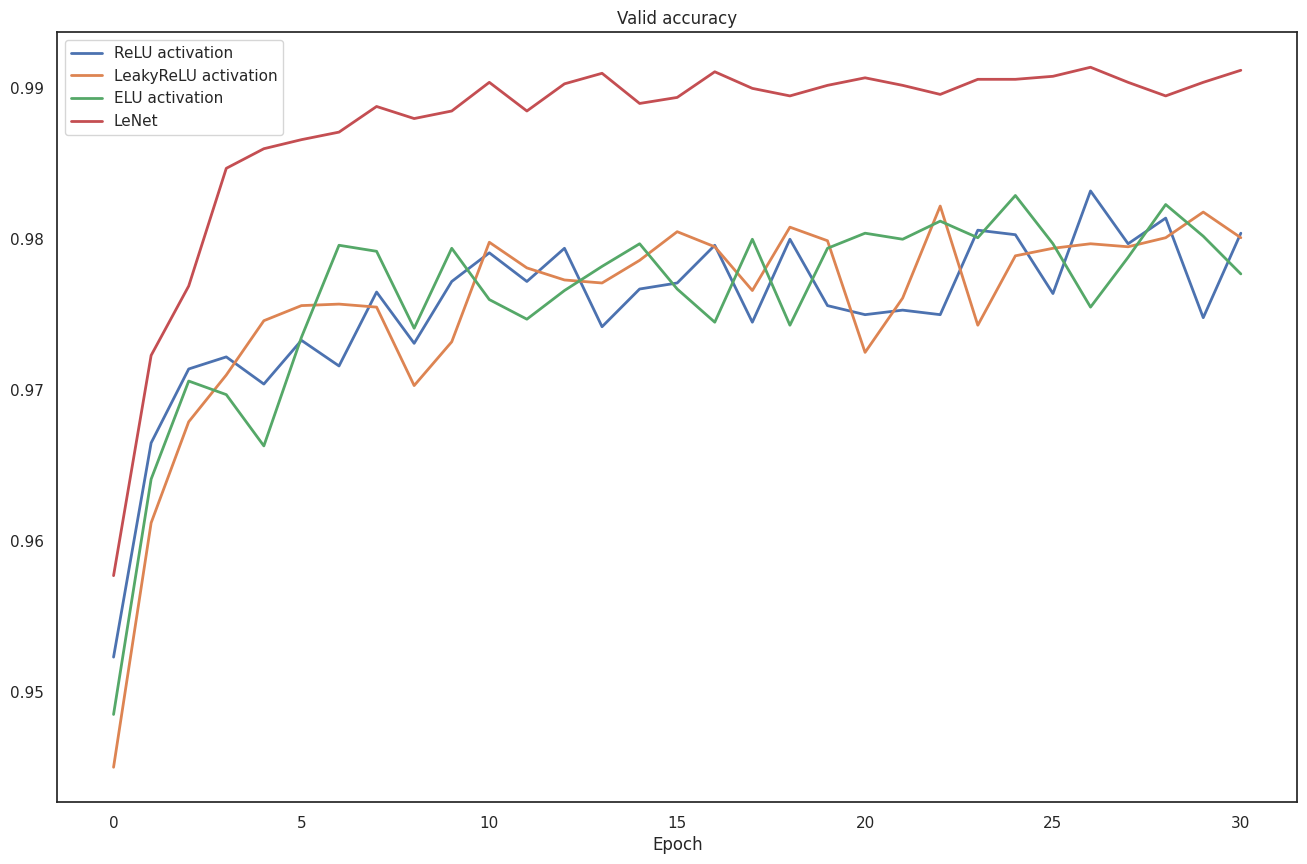

In [30]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(EPOCHS), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(EPOCHS), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(EPOCHS), elu_accuracy["valid"], label="ELU activation", linewidth=2)
plt.plot(range(EPOCHS), lenet_accuracy["valid"], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99